<a href="https://colab.research.google.com/github/musman2012/ml-data_science/blob/master/AMD_Progression/OpenCV/BioMarkersDetected.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mat4py
import matplotlib.pyplot as plt
import numpy as np
import h5py
from mat4py import loadmat

#data = loadmat('/content/2macula.mat')


In [2]:
from google.colab import drive
drive.mount('/content/drive/')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as io
import matplotlib.image as mpimg
import cv2 #as cv

#matfile = io.loadmat('/content/2macula.mat')


In [4]:

## This implementation is based on following research paper:
## https://www.longdom.org/open-access/contribution-to-intraretinal-fluid-segmentation-in-optical-coherence-tomography-by-using-automatic-personalized-thresholding-2155-9570-1000738.pdf

This code is an implementation of [this research paper](https://www.longdom.org/open-access/contribution-to-intraretinal-fluid-segmentation-in-optical-coherence-tomography-by-using-automatic-personalized-thresholding-2155-9570-1000738.pdf)


In [5]:
def show_img(img2show):
  fig = plt.figure(figsize=(5, 5))
  plt.imshow(img)
  plt.show()

In [6]:
## Apply denoising (Median Filters [23,24,37] )
## 3 × 3 pixels 
def apply_median_filter(in_img):
  filtered_img = cv2.medianBlur(img, 3)
  #show_img(filtered_img)
  return filtered_img

In [7]:
## Apply K-Mean Clustering (Color Quantization)
def apply_k_mean_clustering(in_img):
  Z = in_img.reshape((-1,3))
  # convert to np.float32
  Z = np.float32(Z)
  # define criteria, number of clusters(K) and apply kmeans()
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  K = 2
  ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
  # Now convert back into uint8, and make original image
  center = np.uint8(center)
  res = center[label.flatten()]
  res2 = res.reshape((in_img.shape))
  return res2
  #cv2.imshow('res2',res2)
  #show_img(res2)
  #fig = plt.figure(figsize=(5, 5))
  #plt.imshow(res2)
  #plt.show()
  #cv2.waitKey(0)
  #cv2.destroyAllWindows()


In [8]:
### Apply Canny Edge Detector
def apply_canny_edge(in_img):
  edges = cv2.Canny(in_img,50,200)

  return edges
  #fig = plt.figure(figsize=(5, 5))
  #plt.imshow(edges)
  #plt.show()

In [9]:
def find_high_intensity_areas(in_img, th):
  resultr, resultc = [], []
  rows, cols = in_img.shape
  for col in range(cols):
    for row in range(rows):
      if in_img[row, col] > th:
        #temp = (row, col)
        resultr.append(row)
        resultc.append(col)
      
  return (resultr, resultc)

In [10]:
## Detect position of ILM
def detect_ilm1(in_img):
  #print(edges.shape) ## 390, 508 ==> Rows x Cols
  rows, cols = in_img.shape
  center = cols//2
  center += 50
  c_flag = 0
  ilm_pos = []
  ilm_dict = dict()
  seg_img = np.zeros((rows, cols), np.uint8)
  prev_row = 0
  max_diff = 65
  for col in range(center, cols):
    for row in range(rows):
      c_flag = 0
      #if col == center:
      if in_img[row, col] > 200:
        for index in range(1, max_diff):
          temp_index = row + index
          if temp_index >= 390 or index == max_diff:
            #print("reached at the end")
            break
          if in_img[temp_index, col] > 200 and (abs(prev_row - temp_index) < 5 or prev_row == 0):
            #print("new layer detected")
            pos = (temp_index, col)
            ilm_dict[col] = temp_index
            ilm_pos.append(pos)
            prev_row = temp_index
            c_flag = 1
            break
        
        if c_flag == 0:
          if col in ilm_dict:
            break

          pos = (row, col)
          ilm_dict[col] = row
          ilm_pos.append(pos)
            #print("In the loop", row, col)
          prev_row = row
          break

        break
        '''
      if in_img[row, col] > 200 and (abs(prev_row - row) < 5 or prev_row == 0):
        seg_img[row, col] = 255
        pos = (row, col)
        ilm_dict[col] = row
        ilm_pos.append(pos)
        #print("In the loop", row, col)
        prev_row = row
        break
        '''

  prev_row = 0
  for col in range(center-1, -1, -1):
    for row in range(rows):
      if in_img[row, col] > 200 and (abs(prev_row - row) < 5 or prev_row == 0):
        seg_img[row, col] = 255
        pos = (row, col)
        ilm_pos.append(pos)
        ilm_dict[col] = row
        #print("In the loop", row, col)
        prev_row = row
        break
  
  
  return ilm_pos, ilm_dict
  #fig = plt.figure(figsize=(5, 5))
  #plt.imshow(seg_img)
  #plt.show()

In [11]:
## now we know that 
def find_RPE_col(rows, cols, in_loc):
  rpe_pos = []
  counter = 0

  for r in rows:
    if r == in_loc:
      break
    counter += 1

  return cols[counter]

## here we know the index of high intensity row



In [48]:
def detect_ilm(in_img):
  #print(edges.shape) ## 390, 508 ==> Rows x Cols
  rows, cols = in_img.shape
  center = 200 #cols//2 - 10
  center += 50
  ilm_pos = []
  ilm_dict = dict()
  seg_img = np.zeros((rows, cols), np.uint8)
  prev_row = 0
  min_row = 999
  for col in range(center, cols):
    for row in range(rows):
      if in_img[row, col] > 200: #and (abs(prev_row - row) < 5 or prev_row == 0):
        if abs(prev_row - row) < 5 or col < 320:
          seg_img[row, col] = 255
          pos = (row, col)
          ilm_dict[col] = row
          ilm_pos.append(pos)
          min_row = min(row, min_row)
          #print("In the loop", row, col)
          prev_row = row
          break

  prev_row = 0
  for col in range(center-1, -1, -1):
    for row in range(rows):
      if in_img[row, col] > 200: #and (abs(prev_row - row) < 5 or prev_row == 0):
        if abs(prev_row - row) < 5 or col > 100:
          seg_img[row, col] = 255
          pos = (row, col)
          ilm_pos.append(pos)
          ilm_dict[col] = row
          min_row = min(row, min_row)
          #print("In the loop", row, col)
          prev_row = row
          break
  
  
  return ilm_pos, ilm_dict, min_row, seg_img

In [ ]:
#(hi_rows, high_cols) = find_high_intensity_areas(gray)
#print(hi_rows.median())

In [ ]:
#gray = cv2.cvtColor(filtered_img, cv2.COLOR_BGR2GRAY)
# perform a naive attempt to find the (x, y) coordinates of
# the area of the image with the largest intensity value
#(minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(gray)
#cv2.circle(img_ilm, maxLoc, 5, (255, 0, 0), 2)


In [ ]:
def segment_rpe1(gray_img, rpe_col, rpe_row, t_cols):
  rpe_pos = []
  rpe_dict = dict()
  sliding_row = rpe_row
  temp1 = (sliding_row, rpe_col)
  max_rows, max_cols = gray_img.shape
  rpe_dict[rpe_col] = sliding_row
  rpe_pos.append(temp1)
  int_thr = 170
  prev_row2 = sliding_row
  prev_row1 = sliding_row
  ### Use these rows to track previous two values of rows
  ## next row should be prev_row1 + (prev_row1 - prev_row2)
  prev_pos_tracker = 0
  for c in range(rpe_col-1, 0, -1):
    
    for index in range(1, 10):
      flag = 0
      if sliding_row + index < max_rows:
        max_val  = gray_img[sliding_row+index, c]
        max_index = sliding_row + index
      

        if gray_img[sliding_row + index, c] > int_thr:
            if gray_img[sliding_row + index, c] > gray_img[sliding_row - index, c]:
              sliding_row += index
              temp = (sliding_row, c)
              rpe_dict[c] = sliding_row
              rpe_pos.append(temp)
              flag = 1
              break

      #if gray_img[sliding_row - index, c] > max_val:
       # max_val  = gray_img[sliding_row-index, c]
       # max_index = sliding_row - index

      if gray_img[sliding_row - index, c] > int_thr:
        sliding_row -= index
        temp = (sliding_row, c)
        rpe_dict[c] = sliding_row
        rpe_pos.append(temp)
        flag = 1
        break

    #if prev_pos_tracker % 3 == 1:
    
      
    #elif prev_pos_tracker % 3 == 2:
    prev_row2 = prev_row1
    prev_row1 = sliding_row

    

    if flag == 0:
      new_row = prev_row1 + (prev_row1 - prev_row2)
      temp = (new_row, c)
      rpe_dict[c] = new_row
      rpe_pos.append(temp)
      
  sliding_row = rpe_row
  prev_row2 = sliding_row
  prev_row1 = sliding_row
  for c in range(rpe_col, t_cols):
    for index in range(1, 10):
      '''
      if sliding_row + index < t_cols:
        val = gray_img[sliding_row + index, c]
        #print(val)
        if val > max_val:
          max_val = gray_img[sliding_row + index, c]
          max_index = sliding_row + index

      if sliding_row - index >= 0:
        val = gray_img[sliding_row - index, c]
        if gray_img[sliding_row - index, c] > max_val:
          max_val = gray_img[sliding_row - index, c]
          max_index = sliding_row - index
      '''
      flag = 0
      if sliding_row + index < max_rows:
        if gray_img[sliding_row + index, c] > int_thr:
          if gray_img[sliding_row + index, c] > gray_img[sliding_row - index, c]:
            sliding_row += index
            temp = (sliding_row, c)
            rpe_dict[c] = sliding_row
            rpe_pos.append(temp)
            flag = 1
            break

      elif gray_img[sliding_row - index, c] > int_thr:
        sliding_row -= index
        temp = (sliding_row, c)
        rpe_dict[c] = sliding_row
        rpe_pos.append(temp)
        flag = 1
        break

    prev_row2 = prev_row1
    prev_row1 = sliding_row

    if flag == 0:
      new_row = prev_row1 + (prev_row1 - prev_row2)
      temp = (new_row, c)
      rpe_dict[c] = new_row
      rpe_pos.append(temp)

      
  
  return rpe_pos, rpe_dict

In [13]:
def segment_rpe1(gray_img, rpe_col, rpe_row, t_cols):
  rpe_pos = []
  rpe_dict = dict()
  sliding_row = rpe_row
  temp1 = (sliding_row, rpe_col)
  rpe_dict[rpe_col] = sliding_row
  rpe_pos.append(temp1)
  int_thr = 170
  prev_row2 = sliding_row
  prev_row1 = sliding_row
  ### Use these rows to track previous two values of rows
  ## next row should be prev_row1 + (prev_row1 - prev_row2)
  prev_pos_tracker = 0
  for c in range(rpe_col-1, 0, -1):
    
    for index in range(1, 10):
      flag = 0
      max_val  = gray_img[sliding_row+index, c]
      max_index = sliding_row + index
      '''
      if sliding_row + index < t_cols:
        val = gray_img[sliding_row + index, c]
        print(val)
        if val > max_val:
          max_val = gray_img[sliding_row + index, c]
          max_index = sliding_row + index

      if sliding_row - index >= 0:
        val = gray_img[sliding_row - index, c]
        if gray_img[sliding_row - index, c] > max_val:
          max_val = gray_img[sliding_row - index, c]
          max_index = sliding_row - index
      
      
      temp = (max_index, c)
      rpe_dict[c] = max_index
      rpe_pos.append(temp)
      
      if gray_img[sliding_row + index, c] > max_val:
        max_val  = gray_img[sliding_row+index, c]
        max_index = sliding_row + index
      '''

      if gray_img[sliding_row + index, c] > int_thr:
        if gray_img[sliding_row + index, c] > gray_img[sliding_row - index, c]:
          sliding_row += index
          temp = (sliding_row, c)
          rpe_dict[c] = sliding_row
          rpe_pos.append(temp)
          flag = 1
          break

      #if gray_img[sliding_row - index, c] > max_val:
       # max_val  = gray_img[sliding_row-index, c]
       # max_index = sliding_row - index

      if gray_img[sliding_row - index, c] > int_thr:
        sliding_row -= index
        temp = (sliding_row, c)
        rpe_dict[c] = sliding_row
        rpe_pos.append(temp)
        flag = 1
        break

    #if prev_pos_tracker % 3 == 1:
    
      
    #elif prev_pos_tracker % 3 == 2:
    prev_row2 = prev_row1
    prev_row1 = sliding_row

    

    if flag == 0:
      new_row = prev_row1 + (prev_row1 - prev_row2)
      temp = (new_row, c)
      rpe_dict[c] = new_row
      rpe_pos.append(temp)
      
  sliding_row = rpe_row
  prev_row2 = sliding_row
  prev_row1 = sliding_row
  for c in range(rpe_col, t_cols):
    for index in range(1, 10):
      '''
      if sliding_row + index < t_cols:
        val = gray_img[sliding_row + index, c]
        #print(val)
        if val > max_val:
          max_val = gray_img[sliding_row + index, c]
          max_index = sliding_row + index

      if sliding_row - index >= 0:
        val = gray_img[sliding_row - index, c]
        if gray_img[sliding_row - index, c] > max_val:
          max_val = gray_img[sliding_row - index, c]
          max_index = sliding_row - index
      '''
      flag = 0
      if gray_img[sliding_row + index, c] > int_thr:
        if gray_img[sliding_row + index, c] > gray_img[sliding_row - index, c]:
          sliding_row += index
          temp = (sliding_row, c)
          rpe_dict[c] = sliding_row
          rpe_pos.append(temp)
          flag = 1
          break

      elif gray_img[sliding_row - index, c] > int_thr:
        sliding_row -= index
        temp = (sliding_row, c)
        rpe_dict[c] = sliding_row
        rpe_pos.append(temp)
        flag = 1
        break

    prev_row2 = prev_row1
    prev_row1 = sliding_row

    if flag == 0:
      new_row = prev_row1 + (prev_row1 - prev_row2)
      temp = (new_row, c)
      rpe_dict[c] = new_row
      rpe_pos.append(temp)

      
  
  return rpe_pos, rpe_dict

In [14]:
def return_avg(starting_index, col_val, hi_cols, hi_rows):
  counter = sum = 0
  while hi_cols[starting_index] == col_val:
    sum += hi_rows[starting_index]
    starting_index += 1
    counter += 1
    if starting_index < len(hi_cols):
      break

  return sum//counter, starting_index

In [15]:
def segment_rpe(hi_rows, hi_cols, size):
  rpe_pos = []
  rpe_dict = dict()
  c_index = 0
  col_ptr = 0
  prev_row = 0

  for c_index in range(0, size):
    #while high_cols[c_index] == c_index:
    while col_ptr < len(hi_cols) and hi_cols[col_ptr] == c_index:
      col_ptr += 1
    temp = hi_rows[col_ptr-1], c_index
    rpe_pos.append(temp)
    rpe_dict[c_index] = hi_rows[col_ptr-1]
    '''
    if col_ptr < len(hi_cols) and hi_cols[col_ptr] == c_index: ## this column has certain bright spots
      aveg, ending_index = return_avg(col_ptr, c_index, hi_cols, hi_rows)
      prev_row = aveg
    
    else:
      aveg = prev_row
      temp = aveg, c_index
      rpe_pos.append(temp)
      rpe_dict[c_index] = aveg
      col_ptr += 1
    '''
  return rpe_pos, rpe_dict



In [16]:
def estimate_rpe(bm_pos_curve, rpe_pos_curve, total_cols):
  segmented_pos = []
  pos_dict = dict()
  max_row = 0
  for counter in range(0,76):
    bmr, bmc = bm_pos_curve[counter]
    rper, rpec = rpe_pos_curve[counter]
    tr = min(bmr, rper) 
    temp = tr, counter #bm_pos_curve[counter]
    segmented_pos.append(temp)
    max_row = max(tr, max_row)
    pos_dict[counter] = tr

  for counter in range(76, 326):
    temp = rpe_pos_curve[counter]
    tr, tc = temp
    segmented_pos.append(temp)
    max_row = max(tr, max_row)
    pos_dict[counter] = tr

  for counter in range(326, total_cols):
    temp = bm_pos_curve[counter]
    tr, tc = temp
    segmented_pos.append(temp)
    max_row = max(tr, max_row)
    pos_dict[counter] = tr

  #counter = 350

  ## starting from this counter:
  ## Phase-I ==> replace rpe pos with bm_pos_curve
  ## Plus do the same for first 50 cols
  ##########################################
  ## Phase-II ==> Check the difference in both curves and make decision

  #r,c = bm_pos_curve[counter]

  #print("Row col", r, c)

  return segmented_pos, pos_dict, max_row


In [17]:
def find_starting_row_fluid(ilm_dict, counter):
  if counter in ilm_dict:
      starting_row = ilm_dict[counter] + 15
      return starting_row
  else:
    for i in range(10):
      if counter-i in ilm_dict:
        starting_row = ilm_dict[counter-i]
        return starting_row

      elif counter+i in ilm_dict:
        starting_row = ilm_dict[counter+i]
        return starting_row

  return -999


In [18]:
def find_ending_row_fluid(rpe_dict, counter):
  if counter in rpe_dict:
      starting_row = rpe_dict[counter]
      return starting_row
  else:
    for i in range(150):
      if counter-i in rpe_dict:
        starting_row = rpe_dict[counter-i]
        return starting_row

      elif counter+i in rpe_dict:
        starting_row = rpe_dict[counter+i]
        return starting_row

  return -99


In [19]:
def seg_fluid(gray_img, ilm_pos, rpe_pos, thershld, thershld2, ilm_dict, rpe_dict):
  ## length of rows should be equal to number of cols
  ilm_rows, ilm_cols, rpe_rows, rpe_cols = [],[],[],[]
  MAX_ROW, MIN_ROW = 0,0
  NUM_ROWS, NUM_COLS = gray_img.shape
  fluid_pos = []

  for ilms in ilm_pos:
    (row, col) = ilms
    ilm_rows.append(row)
    ilm_cols.append(col)

  for rpes in rpe_pos:
    (row, col) = rpes
    rpe_rows.append(row)
    rpe_cols.append(col)

  MAX_ROW = max(rpe_rows)
  MIN_ROW = min(ilm_rows)

 # print(len(ilm_rows))
  #print(gray_img.shape)

  counter = -1
  prev_ending_row = MAX_ROW
  prev_starting_row = MIN_ROW

  NUM_COLS -= 30      ## ignoring the noise at the right side

  for c in range(NUM_COLS):
    counter += 1
    starting_row = find_starting_row_fluid(ilm_dict, counter)
    ending_row = find_ending_row_fluid(rpe_dict, counter)
    #print("Ending nrw", ending_row, counter, NUM_COLS)
    if ending_row == -99 or ending_row is None:
      ending_row = prev_ending_row

    if starting_row == -999:
      starting_row = prev_starting_row
      
    while starting_row <= ending_row:
    #for r in range(starting_row, MAX_ROW):  ## TODO-2 MAKE IT DEPENDENT ON RPE VAL HERE
      #print("Starting row is",starting_row)
      r = starting_row
      if gray_img[r, c] > thershld and gray_img[r, c] < thershld2:
        temp = (r, c)
        #resultr.append(row)
        fluid_pos.append(temp)
      starting_row += 1
    prev_ending_row = ending_row
    prev_starting_row = starting_row

  return fluid_pos, MAX_ROW, MIN_ROW


In [20]:
def seg_fluid1(gray_img, ilm_pos, rpe_pos, thershld, thershld2, ilm_dict, rpe_dict):
  ## length of rows should be equal to number of cols
  ilm_rows, ilm_cols, rpe_rows, rpe_cols = [],[],[],[]
  MAX_ROW, MIN_ROW = 0,0
  NUM_ROWS, NUM_COLS = gray_img.shape
  fluid_pos = []

    for c in range(NUM_COLS):
    counter += 1
    starting_row = find_starting_row_fluid(ilm_dict, counter)
    ending_row = find_ending_row_fluid(rpe_dict, counter)
    #print("Ending nrw", ending_row, counter, NUM_COLS)
    if ending_row == -99 or ending_row is None:
      ending_row = prev_ending_row

    if starting_row == -999:
      starting_row = prev_starting_row
      
    while starting_row <= ending_row:
    #for r in range(starting_row, MAX_ROW):  ## TODO-2 MAKE IT DEPENDENT ON RPE VAL HERE
      r = starting_row
      if gray_img[r, c] > thershld and gray_img[r, c] < thershld2:
        temp = (r, c)
        #resultr.append(row)
        fluid_pos.append(temp)
      starting_row += 1
    prev_ending_row = ending_row
    prev_starting_row = starting_row




  return fluid_pos

IndentationError: ignored

In [21]:
def remove_intensity_outliers1(ilm_mode, ilm_dict, hi_r, hi_c):
  new_rows, new_cols = [],[]
  index = 0
  PIXEL_DIFF_TH, th2 = 35, 20
  IMP_COL = 100
  #print("ILM MODE ", ilm_mode)
  '''
  for c in hi_c:
    ## in each column, remove two outliers
    ## (i) values above ilm
    ## (ii) values 30 pixel under that point
    if index in ilm_dict:
      if ilm_dict[index] > hi_r[index]:
        continue

      #if abs(ilm_dict[index] - hi_r[index]) < 30:
       # continue

      new_rows.append(c)
      new_cols.append(hi_r[index])


  '''
  for r in hi_r:
    
    if index > len(hi_c):
      continue

    if IMP_COL in ilm_dict:
      if abs(r - ilm_dict[IMP_COL]) < th2:
        continue
    #if index in ilm_dict:
     # print("Row from intensity , ILM and Column", r, ilm_dict[index], index)
      #if r > ilm_dict[index] or abs(r-ilm_dict[index]) < 40:
       # continue

    if abs(r - ilm_mode) > PIXEL_DIFF_TH:
      new_rows.append(r)
      new_cols.append(hi_c[index])

    index += 1
    

  return new_rows, new_cols

In [22]:
def remove_extremes(new_rows, new_cols):
  rows, cols = [], []
  r_mode = stats.mode(new_rows)
  r_mode = r_mode[0][0]

  for i in range(0, len(new_rows)):
    if r_mode - new_rows[i] > 70:
      continue
    rows.append(new_rows[i])
    cols.append(new_cols[i])
  
  return rows, cols

In [23]:
def remove_intensity_outliers(ilm_mode, ilm_dict, hi_r, hi_c):
  new_rows, new_cols = [],[]
  #index = 0
  PIXEL_DIFF_TH, th2 = 50, 20
  IMP_COL = 100

  for index in range(0, len(hi_r)):
    c = hi_c[index]
    r = hi_r[index]
    flag = 0
    #print(c,r)
    if c in ilm_dict:
      if (r - ilm_dict[c]) < PIXEL_DIFF_TH:
        flag = 1
    else:
      for i in range(1,6):
        new_c = index + i
        if new_c in ilm_dict:
          if (r - ilm_dict[new_c]) < PIXEL_DIFF_TH:
            flag = 1

        new_c = index - i
        if new_c in ilm_dict:
          if (r - ilm_dict[new_c]) < PIXEL_DIFF_TH:
            flag = 1
    
    if flag == 1:
      continue
        
    #print("Vals appended", index)
    new_rows.append(r)
    new_cols.append(c)
    
#   index += 1

  new_rows, new_cols = remove_extremes(new_rows, new_cols)

  return (new_rows, new_cols)


In [24]:
from scipy import stats

def return_vals(my_dict):
  vals = []
  for key in my_dict:
    vals.append(my_dict[key])

  return vals

In [25]:
from collections import Counter 

def estimate_rpe1(new_hi_rows, new_hi_cols, rpe_col):
  r_mode = stats.mode(new_hi_rows)
  countes = Counter(new_hi_rows) 
  second_frq = countes.most_common(2)[0][0]
  r_mode = r_mode[0][0]
  s_index = 0
  prev1, prev2 = 0,0
  for r in new_hi_rows:
    if r == second_frq:
      break
    s_index += 1

  last = len(new_hi_cols) - 1
  second = max(rpe_col, s_index)
  first = min(rpe_col, s_index)
  
  ## last part
  prev2 = new_hi_rows[second]
  prev1 = new_hi_rows[second + 1] ## moving to the right first

  

  ## now we know the index from where to start
  for i in range(second+2, ):
    if abs(prev1 - new_hi_rows[i]) > 10:  ## outlier
      new_hi_rows[i] = prev1 + (prev2 - prev1)
    prev2 = prev1
    prev1 = new_hi_rows[i]

  ## second last

  prev2 = new_hi_rows[second]
  prev1 = new_hi_rows[second - 1] ## moving to left

  for i in range(second-2, first-1, -1):
    if abs(prev1 - new_hi_rows[i]) > 10:  ## outlier
      new_hi_rows[i] = prev1 + (prev2 - prev1)
    prev2 = prev1
    prev1 = new_hi_rows[i]

  ## first part

  prev2 = new_hi_rows[first]
  prev1 = new_hi_rows[first - 1] ## moving to left

  for i in range(first-2, -1, -1):
    if abs(prev1 - new_hi_rows[i]) > 10:  ## outlier
      new_hi_rows[i] = prev1 + (prev2 - prev1)
    prev2 = prev1
    prev1 = new_hi_rows[i]



  return new_hi_rows, new_hi_cols



In [26]:
def seg_foci(gray_img, thershld_min, thershld_max, ilm_dict, rpe_dict, MAX_ROW, MIN_ROW, RPE_ROW):
  ## length of rows should be equal to number of cols

  ## another algorithm
  ## detect the bright clusters (Spots) first
  ## pick those clusters having area of less than ___
  ## only those which are below ILM and above RPE
  
  NUM_ROWS, NUM_COLS = gray_img.shape
  foci_pos = []

  #print("rows and cols are ", NUM_ROWS, NUM_COLS)
  
  counter = -1
  prev_ending_row = MAX_ROW
  prev_starting_row = MIN_ROW

  ending_row = prev_ending_row

  for c in range(NUM_COLS):
    counter += 1
    starting_row = find_starting_row_fluid(ilm_dict, counter)
    ending_row = find_ending_row_fluid(rpe_dict, counter)
    #print("Ending nrw", ending_row, counter, NUM_COLS)
    #if ending_row == -99 or ending_row is None:
    ##  ending_row = prev_ending_row

    if starting_row == -999:
      starting_row = prev_starting_row

    starting_row += 20
    ending_row -= 20
      
    while starting_row <= ending_row and starting_row < NUM_ROWS:
    #for r in range(starting_row, MAX_ROW):  ## TODO-2 MAKE IT DEPENDENT ON RPE VAL HERE
      #print("Starting row is",starting_row)
      r = starting_row
      #if abs(r - RPE_ROW) < 10:
      #  continue
      
      if gray_img[r, c] > thershld_min and gray_img[r, c] < thershld_max:
        temp = (r, c)
        #resultr.append(row)
        foci_pos.append(temp)
      starting_row += 1
    prev_ending_row = ending_row
    prev_starting_row = starting_row

  return foci_pos

In [27]:
def cluster_fluid_edges(edges_img, segmented_rpe_dict, ilm_dict):
  empty_img = np.zeros((gray.shape[0], gray.shape[1]), np.uint8)
  t_cols = len(segmented_rpe_dict)
  #print("total cols are ", t_cols, len(segmented_rpe_dict))
  center = t_cols // 2
  lower_bound = 15
  p_start_row, p_end_row = ilm_dict[center], segmented_rpe_dict[center]
  for c in range(center-1, -1, -1):
    start_row = p_start_row
    end_row = p_end_row
    if c in ilm_dict:
      start_row = ilm_dict[c]
    end_row = segmented_rpe_dict[c]
    empty_img[start_row + 5: end_row+lower_bound, c] = edges_img[start_row + 5: end_row+lower_bound, c]
    p_start_row = start_row
    p_end_row = end_row

  for c in range(center+1, t_cols):
    start_row = p_start_row
    end_row = p_end_row
    if c in ilm_dict:
      start_row = ilm_dict[c]
    end_row = segmented_rpe_dict[c]
    empty_img[start_row + 5: end_row+lower_bound, c] = edges_img[start_row + 5: end_row+lower_bound, c]
    p_start_row = start_row
    p_end_row = end_row

  #for val in segmented_rpe_dict:
   # empty_img[segmented_rpe_dict[val], val] = 255

  return empty_img


In [28]:

def locate_fluid_from_clusters(fluid_clus, segmented_rpe_dict):
  new_fluid_pos = []
  t_rows, t_cols = fluid_clus.shape
  min_row = 100
  max_row = t_rows
  #t_cols = len(segmented_rpe_dict)
  for c in range(0, t_cols):
    max_row = segmented_rpe_dict[c]
    for r in range(min_row, t_rows):
      if fluid_clus[r,c] > 100:     ## starting row detected
        temp = (r,c)
        new_fluid_pos.append(temp)
        counter = 1
        while ((r+counter) < max_row) and fluid_clus[r+counter,c] < 100:
           temp = (r+counter,c)
           new_fluid_pos.append(temp)
           counter += 1
        break

  return new_fluid_pos


In [29]:
pip install python-docx     ## would only be needed if the output has to be in a docx file

     |████████████████████████████████| 5.5MB 5.0MB/s 
  Created wheel for python-docx: filename=python_docx-0.8.10-cp36-none-any.whl size=184491 sha256=9c955224c52b27108c52d871e6ded18770a11a20d2a4f8b1fde0afcb9c9dd9b6
  Stored in directory: /root/.cache/pip/wheels/18/0b/a0/1dd62ff812c857c9e487f27d80d53d2b40531bec1acecfa47b
Successfully built python-docx


In [30]:
def abrupt_change_fluid(gray, foci_mn_th, foci_mx_th, ilm_dict, segmented_rpe_dict, mx_row, mn_row, rpe_row):
  t_cols = gray.shape[1]
  temp_f_pos = []
  for col in range(0, t_cols):
    min_row = mn_row
    max_row = mx_row
    if col in ilm_dict:
      min_row = ilm_dict[col]
    if col in rpe_dict:
      max_row = rpe_dict[col]

    row = min_row + 10
    prev_val = gray[row,col]
    while row < max_row:
      if abs(gray[row,col] - prev_val) > 250:
        temp = (row,col)
        temp_f_pos.append(temp)
      prev_val = gray[row,col]
      row += 5

  return temp_f_pos
  ### start from the ILM pos
  ### Go until RPE
  ## See if the difference is more than a specific value
  ## add to list

In [31]:
def fluid_clustering(in_img):
  Z = in_img.reshape((-1,3))
  # convert to np.float32
  Z = np.float32(Z)
  # define criteria, number of clusters(K) and apply kmeans()
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  K = 3
  ret,label,center=cv2.kmeans(Z,K,None,criteria,100,cv2.KMEANS_RANDOM_CENTERS)
  # Now convert back into uint8, and make original image
  center = np.uint8(center)
  res = center[label.flatten()]
  res2 = res.reshape((in_img.shape))
  return res2

In [32]:
def find_ret_contours(gray_in, max_rpe_row, min_ilm_row):
  rows, cols = gray_in.shape
  out_img = md_img.copy()
  contours, hierarchy = cv2.findContours(gray_in, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
  areas = []
  for cntr in contours:
    flag = 1
    #area = cv2.contourArea(cntr)
    #areas.append(area)
    #print(cntr)
    # for (r,c) in cntr:
    #   if min_ilm_row > r or r > max_rpe_row:
    #     flag = 0
    #     break
    #if area < 200 or area > 200:
      #eps = 0.01 * cv2.arcLength(cntr, True)
      #approx = cv2.approxPolyDP(cntr, eps, True)
    out_img = cv2.drawContours(out_img, [cntr], 0, (0,255,0), 3) ## -1 indicates drawing ALL, then the color

  return out_img, areas

In [33]:
def detect_roi(gray_th, ilm_pos, rpe_pos, ilm_dict, bm_pos_curve_dict):
  ilm_rows, rpe_rows = [],[]
  MAX_ROW, MIN_ROW = 0,0
  ROI = np.ones(gray_th.shape, np.uint8)
  NUM_COLS = gray_th.shape[1]

  for ilms in ilm_pos:
    (row, col) = ilms
    ilm_rows.append(row)

  for rpes in rpe_pos:
    (row, col) = rpes
    rpe_rows.append(row)

  MAX_ROW = max(rpe_rows)
  MIN_ROW = min(ilm_rows)
  
  for c in range(0, NUM_COLS):
    if c in ilm_dict:
      MIN_ROW = ilm_dict[c]

    if c in rpe_dict:
      MAX_ROW = rpe_dict[c]
    
    ROI[MIN_ROW+5:MAX_ROW, c] = gray_th[MIN_ROW+5:MAX_ROW, c]

  
  return ROI

In [34]:
## calculate the distance between yellow and green lines
## if its more than a specific threshold ==> Make the yellow line a bit (10 rows) down 
def return_dist(first_line_dict, second_line_dict):
  length = len(first_line_dict)
  distance = 0
  for i in range(100, length - 100, 10):
    if i in second_line_dict and i in first_line_dict:
      distance += abs(first_line_dict[i] - second_line_dict[i])

  return distance


In [35]:
def return_cave_dist(first_line_dict, second_line_dict):
  length = len(first_line_dict)
  distance = 0
  for i in range(10, 211, 10):
    if i < 50 and abs(first_line_dict[i] - first_line_dict[i-2]) > 5:
      continue
    if i in second_line_dict and i in first_line_dict:
      distance += abs(first_line_dict[i] - second_line_dict[i])

  return distance

In [36]:
def adjust_bm(distance, so_pos_curve_dict, so_pos_curve):
  residue = 0
  length = len(so_pos_curve_dict)
  # if distance > 300: ##
  #   residue += 10

  # if distance > 150: ##
  #   residue += 20

  # if distance > 800:
  #   residue -= 30

  for i in range(100, length - 100):
    so_pos_curve_dict[i] += residue
    temp = (so_pos_curve_dict[i], i)
    so_pos_curve[i] = temp
    #distance += abs(first_line_dict[i] - second_line_dict[i])

  return so_pos_curve_dict, so_pos_curve


In [37]:
def seg_ped(gray, so_pos_curve_dict, segmented_rpe_dict):
  length = len(so_pos_curve_dict)
  thresold = 130
  ped_rows = []
  ped_pos = []
  
  #ped_dict = dict()

  for c in range(100, length - 100):
    for r in range(segmented_rpe_dict[c], so_pos_curve_dict[c]):
      if gray[r,c] < thresold:
        temp = (r,c)
        ped_pos.append(temp)
        ped_rows.append(r)
        #ped_dict[c] = 
    
    #temp = (so_pos_curve_dict[i], i)
    #so_pos_curve[i] = temp


  return ped_pos


In [38]:
def resize_img(in_img):
  scale_percent = 30 # percent of original size
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  new_dim = (width, height)

  resized = cv2.resize(in_img, new_dim, interpolation = cv2.INTER_AREA)

  return resized

In [39]:
import skimage.io as io
import skimage.filters as flt
%matplotlib inline
# since we can't use imports
import numpy as np
import scipy.ndimage.filters as flt

def anisodiff1(img,niter=1,kappa=50,gamma=0.1,step=(1.,1.),sigma=0, option=1,ploton=False):
  if img.ndim == 3:
    print("Gray scale img allowed")
    img = img.mean(2)

	# initialize output array
  img = img.astype('float32')
  imgout = img.copy()

	# initialize some internal variables
  deltaS = np.zeros_like(imgout)
  deltaE = deltaS.copy()
  NS = deltaS.copy()
  EW = deltaS.copy()
  gS = np.ones_like(imgout)
  gE = gS.copy()

  # create the plot figure, if requested
  if ploton:
    import pylab as pl
    from time import sleep

		

    fig = pl.figure(figsize=(20,5.5),num="Anisotropic diffusion")
    ax1,ax2 = fig.add_subplot(1,2,1),fig.add_subplot(1,2,2)

    ax1.imshow(img,interpolation='nearest')
    ih = ax2.imshow(imgout,interpolation='nearest',animated=True)
    ax1.set_title("Original image")
    ax2.set_title("Iteration 0")

    fig.canvas.draw()

  for ii in np.arange(1,niter):

    # calculate the diffs
    deltaS[:-1,: ] = np.diff(imgout,axis=0)
    deltaE[: ,:-1] = np.diff(imgout,axis=1)

    if 0<sigma:
      deltaSf=flt.gaussian_filter(deltaS,sigma);
      deltaEf=flt.gaussian_filter(deltaE,sigma);
    else: 
      deltaSf=deltaS;
      deltaEf=deltaE;
			
    # conduction gradients (only need to compute one per dim!)
    if option == 1:
      gS = np.exp(-(deltaSf/kappa)**2.)/step[0]
      gE = np.exp(-(deltaEf/kappa)**2.)/step[1]
    elif option == 2:
      gS = 1./(1.+(deltaSf/kappa)**2.)/step[0]
      gE = 1./(1.+(deltaEf/kappa)**2.)/step[1]

    # update matrices
    E = gE*deltaE
    S = gS*deltaS

    # subtract a copy that has been shifted 'North/West' by one
    # pixel. don't as questions. just do it. trust me.
    NS[:] = S
    EW[:] = E
    NS[1:,:] -= S[:-1,:]
    EW[:,1:] -= E[:,:-1]

    # update the image
    imgout += gamma*(NS+EW)

    if ploton:
      iterstring = "Iteration %i" %(ii+1)
      ih.set_data(imgout)
      ax2.set_title(iterstring)
      fig.canvas.draw()
      # sleep(0.01)

  return imgout

In [40]:
from skimage import data, img_as_float
from skimage.segmentation import chan_vese

def detect_fluid_contours(input_image, max_rpe_row, min_ilm_row):
  md_img = apply_median_filter(input_image)
  gray = cv2.cvtColor(md_img, cv2.COLOR_BGR2GRAY)

  chv = chan_vese(gray, mu=0.25, lambda1=1, lambda2=1, tol=1e-3, max_iter=200,
               dt=0.5, init_level_set="checkerboard", extended_output=True)
  
  data = chv[1].copy()

  im_max = 255
  data = abs(data.astype(np.float64) / data.max()) # normalize the data to 0 - 1
  data = im_max * data # Now scale by 255
  ls_img = data.astype(np.uint8)

  temp = apply_k_mean_clustering(ls_img)
  temp = apply_canny_edge(temp)
  #out_img2, areas = find_ret_contours(temp, max_rpe_row, min_ilm_row)

  return temp

In [41]:
def append_fluid_spots(fluid_spots, start_row, end_row, col, image_scan):
  while start_row < end_row and (image_scan[start_row, col] == 0 or col < 300):
    temp = start_row, col
    fluid_spots.append(temp)
    start_row += 1

  return fluid_spots

In [42]:
def detect_fluid_spots1(detected_fluid_output, segmented_rpe_dict, ilm_dict, min_row, max_row):
  total_cols = 380
  fluid_spots = []
  s_row = min_row
  e_row = max_row
  col_start = 100

  for col in range(total_cols):
    e_row = segmented_rpe_dict[col]
    if col in ilm_dict:
      s_row = ilm_dict[col]
      fluid_spots = append_fluid_spots(fluid_spots, s_row+1, e_row-10, col, detected_fluid_output)

  return fluid_spots
    


In [43]:
def detect_fluid_spots(detected_fluid_output, segmented_rpe_dict, ilm_dict, min_row, max_row):
  ## will only be called in those scans in which the cave is clear
  ## start from the ilm_dict KVP at a specific column
  ## go until the value of segmented_rpe_dict[col] 
  ## append all the values 
  tot_cols = 380 #detected_fluid_output.shape[1]
  fluid_spots = []
  s_row = min_row
  e_row = max_row
  col_start = 90
  fluid_start_row = dict()

  if col_start in ilm_dict:
    s_row = ilm_dict[col_start]

  if col_start in segmented_rpe_dict:
    e_row = segmented_rpe_dict[col_start]
  
  s_row += 10
  
  while s_row < e_row:
    if detected_fluid_output[s_row, col_start] > 0:
      fluid_spots = append_fluid_spots(fluid_spots, s_row+1, e_row, col_start, detected_fluid_output)
      fluid_start_row[col_start] = s_row
      break
    s_row += 1

  ## HERE s_row contains the location of fluid start at col 100
  ## now go right and left
  prev_row = s_row
  #row = s_row - 10     ## starting from a bit up to cover any rocks going up
  for col in range(col_start + 1, tot_cols):    ## go right
    row = prev_row - 10
    if col in segmented_rpe_dict:
      e_row = segmented_rpe_dict[col]
    
    while row < e_row:
      if detected_fluid_output[row, col] > 100:
        fluid_spots = append_fluid_spots(fluid_spots, row+1, e_row, col, detected_fluid_output)
        fluid_start_row[col] = row
        prev_row = row
        break
      row += 1

  prev_row = s_row
  #row = s_row - 10
  for col in range(col_start - 1, -1, -1):    ## go left
    row = prev_row - 10
    if col in segmented_rpe_dict:
      e_row = segmented_rpe_dict[col]
    
    while row < e_row:
      if detected_fluid_output[row, col] > 100:
        fluid_spots = append_fluid_spots(fluid_spots, row+1, e_row, col, detected_fluid_output)
        fluid_start_row[col] = row
        
        prev_row = row
        break
      row += 1

  for c in range(0, tot_cols):
    if c in fluid_start_row:
      continue

    if c-2 in fluid_start_row and c+2 in fluid_start_row:
      e_row = segmented_rpe_dict[c]
      temp_row = (fluid_start_row[c-2]+fluid_start_row[c+2]) // 2
      fluid_spots = append_fluid_spots(fluid_spots, temp_row+1, e_row, c, detected_fluid_output)
      fluid_start_row[c] = temp_row


  return fluid_spots


Lines distance is  83  Brights spots 5501  CAVE  1791


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in ubyte_scalars
  from ipykernel import kernelapp as app


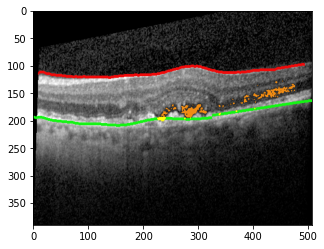

Retinal Fluid Detected Area (µm) : 7632.3
PED Detected Area (µm) : 450.3
Lines distance is  185  Brights spots 4601  CAVE  1806


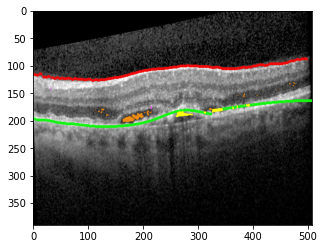

Retinal Fluid Detected Area (µm) : 2713.2
Foci Detected Area (µm) : 39.9
PED Detected Area (µm) : 1254.0
Lines distance is  35  Brights spots 5353  CAVE  1747


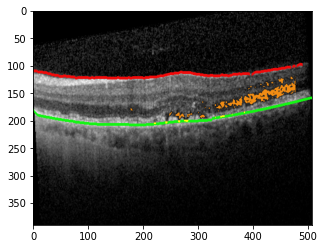

Retinal Fluid Detected Area (µm) : 10225.8
PED Detected Area (µm) : 239.4
Lines distance is  267  Brights spots 3539  CAVE  1747


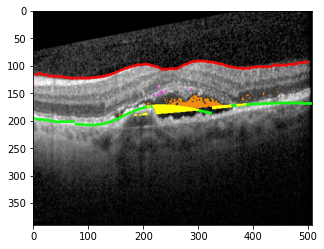

Retinal Fluid Detected Area (µm) : 10220.1
Foci Detected Area (µm) : 199.5
PED Detected Area (µm) : 5922.3
Lines distance is  321  Brights spots 4754  CAVE  1729


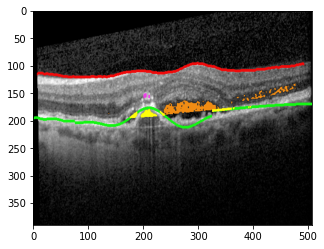

Retinal Fluid Detected Area (µm) : 10322.7
Foci Detected Area (µm) : 159.6
PED Detected Area (µm) : 2223.0
Lines distance is  362  Brights spots 2986  CAVE  1720


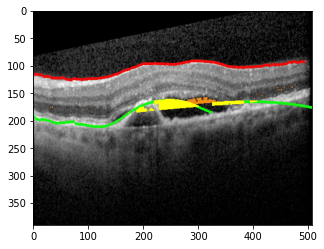

Retinal Fluid Detected Area (µm) : 5403.6
PED Detected Area (µm) : 7729.2
Lines distance is  267  Brights spots 5664  CAVE  1757


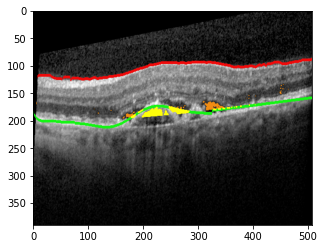

Retinal Fluid Detected Area (µm) : 3317.4
PED Detected Area (µm) : 3972.9
Lines distance is  219  Brights spots 5525  CAVE  1750


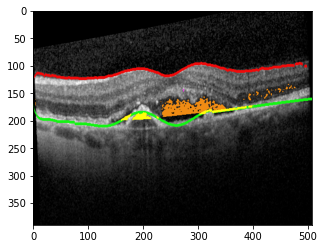

Retinal Fluid Detected Area (µm) : 13189.8
Foci Detected Area (µm) : 11.4
PED Detected Area (µm) : 2793.0
Lines distance is  746  Brights spots 5167  CAVE  1762


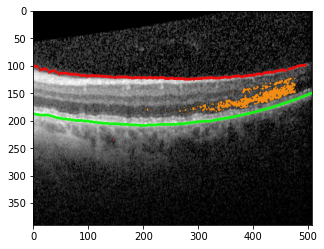

Retinal Fluid Detected Area (µm) : 15458.4
Lines distance is  22737  Brights spots 6031  CAVE  1726


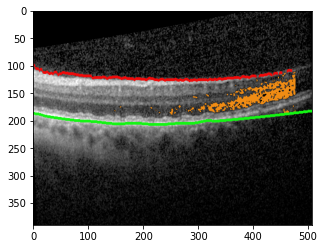

Retinal Fluid Detected Area (µm) : 19602.3
Lines distance is  19  Brights spots 5947  CAVE  1801


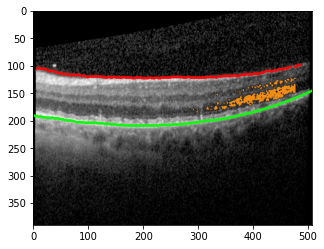

Retinal Fluid Detected Area (µm) : 11023.8
Lines distance is  129  Brights spots 9021  CAVE  1673


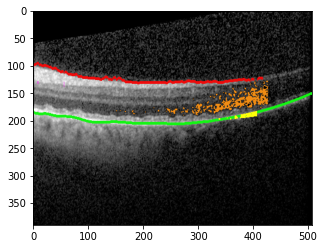

Retinal Fluid Detected Area (µm) : 12260.7
Foci Detected Area (µm) : 45.6
PED Detected Area (µm) : 1140.0
Lines distance is  15  Brights spots 11597  CAVE  1611


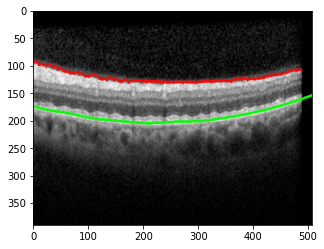

Foci Detected Area (µm) : 22.8
Lines distance is  11  Brights spots 10458  CAVE  1643


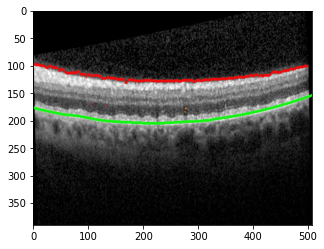

Retinal Fluid Detected Area (µm) : 102.6
Lines distance is  31  Brights spots 9149  CAVE  1722


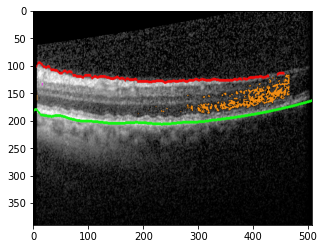

Retinal Fluid Detected Area (µm) : 13936.5
Foci Detected Area (µm) : 11.4
Lines distance is  21  Brights spots 10853  CAVE  1604


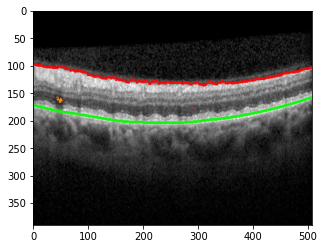

Retinal Fluid Detected Area (µm) : 433.2
Lines distance is  16  Brights spots 11578  CAVE  1624


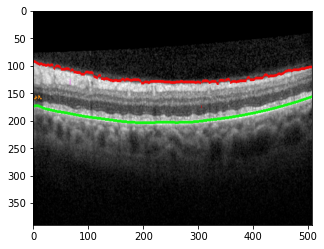

Retinal Fluid Detected Area (µm) : 267.9
Foci Detected Area (µm) : 39.9
Lines distance is  16  Brights spots 7964  CAVE  1369


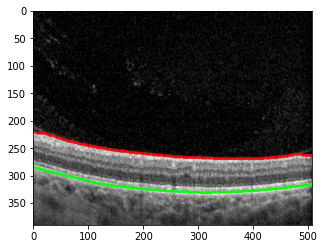

Lines distance is  33  Brights spots 8515  CAVE  1635


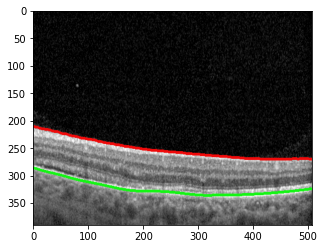

Lines distance is  21  Brights spots 9084  CAVE  1408


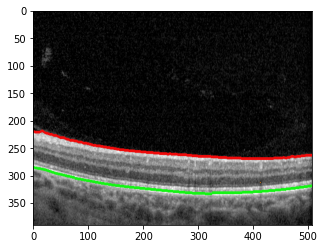

Lines distance is  27  Brights spots 8125  CAVE  1518


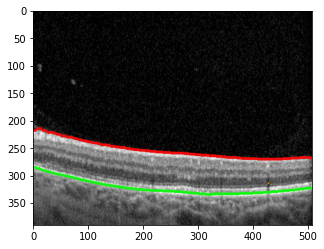

Lines distance is  59  Brights spots 6467  CAVE  1869


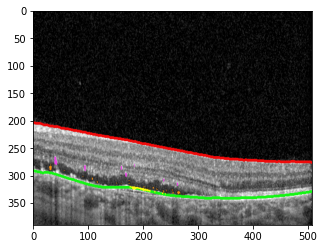

Retinal Fluid Detected Area (µm) : 684.0
Foci Detected Area (µm) : 416.1
PED Detected Area (µm) : 421.8
Lines distance is  67  Brights spots 4440  CAVE  2003


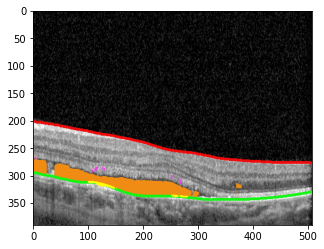

Retinal Fluid Detected Area (µm) : 33208.2
Foci Detected Area (µm) : 307.8
PED Detected Area (µm) : 997.5
Lines distance is  26  Brights spots 7728  CAVE  1701


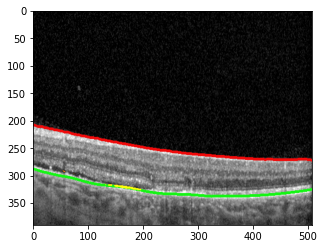

PED Detected Area (µm) : 552.9
Lines distance is  66  Brights spots 4691  CAVE  1806


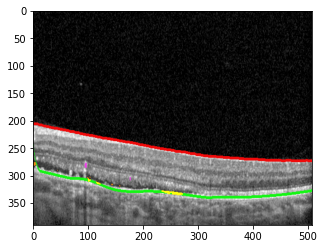

Retinal Fluid Detected Area (µm) : 404.7
Foci Detected Area (µm) : 125.4
PED Detected Area (µm) : 672.6
Lines distance is  70  Brights spots 3364  CAVE  2376


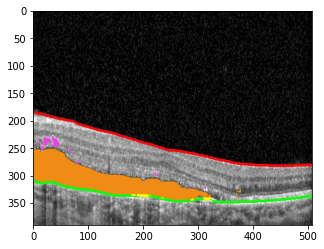

Retinal Fluid Detected Area (µm) : 64529.7
Foci Detected Area (µm) : 1214.1000000000001
PED Detected Area (µm) : 723.9
Lines distance is  14  Brights spots 3500  CAVE  2148


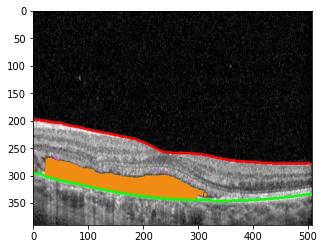

Retinal Fluid Detected Area (µm) : 50838.3
Foci Detected Area (µm) : 228.0
Lines distance is  63  Brights spots 3578  CAVE  2265


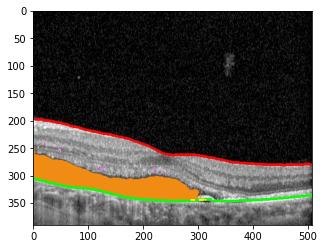

Retinal Fluid Detected Area (µm) : 59433.9
Foci Detected Area (µm) : 159.6
PED Detected Area (µm) : 153.9
Lines distance is  75  Brights spots 6435  CAVE  2684


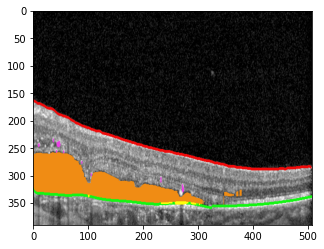

Retinal Fluid Detected Area (µm) : 72173.4
Foci Detected Area (µm) : 530.1
PED Detected Area (µm) : 723.9
Lines distance is  107  Brights spots 5867  CAVE  2478


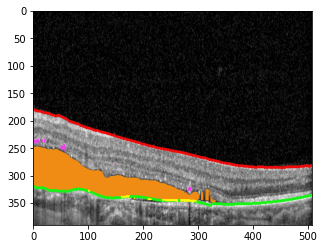

Retinal Fluid Detected Area (µm) : 70503.3
Foci Detected Area (µm) : 621.3000000000001
PED Detected Area (µm) : 991.8000000000001
Lines distance is  73  Brights spots 7121  CAVE  2907


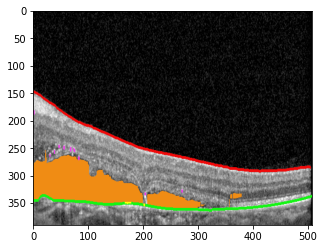

Retinal Fluid Detected Area (µm) : 76699.2
Foci Detected Area (µm) : 410.40000000000003
PED Detected Area (µm) : 125.4
Lines distance is  65  Brights spots 5860  CAVE  3419


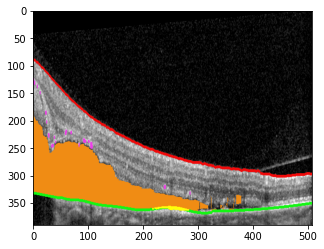

Retinal Fluid Detected Area (µm) : 108784.5
Foci Detected Area (µm) : 1003.2
PED Detected Area (µm) : 1071.6000000000001
Lines distance is  109  Brights spots 3868  CAVE  2498


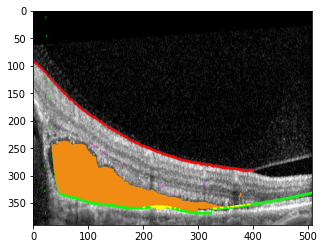

Retinal Fluid Detected Area (µm) : 79999.5
Foci Detected Area (µm) : 290.7
PED Detected Area (µm) : 1122.9


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


Lines distance is  79  Brights spots 7557  CAVE  3336


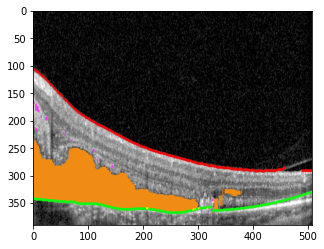

Retinal Fluid Detected Area (µm) : 97903.2
Foci Detected Area (µm) : 490.2
PED Detected Area (µm) : 102.60000000000001
Lines distance is  61  Brights spots 7271  CAVE  3108


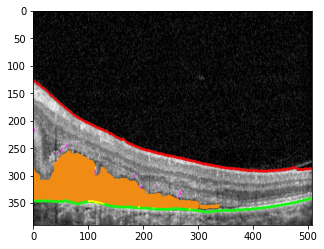

Retinal Fluid Detected Area (µm) : 81880.5
Foci Detected Area (µm) : 490.2
PED Detected Area (µm) : 364.8


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


Lines distance is  42  Brights spots 4098  CAVE  3410


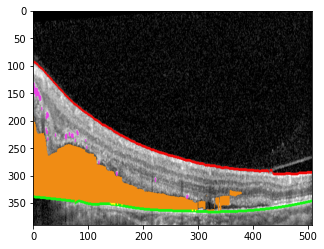

Retinal Fluid Detected Area (µm) : 105410.1
Foci Detected Area (µm) : 1653.0
PED Detected Area (µm) : 114.0
Lines distance is  53  Brights spots 8565  CAVE  2804


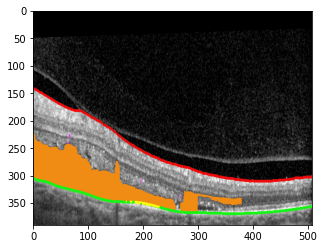

Retinal Fluid Detected Area (µm) : 77696.7
Foci Detected Area (µm) : 96.9
PED Detected Area (µm) : 741.0
Lines distance is  52  Brights spots 9053  CAVE  2972


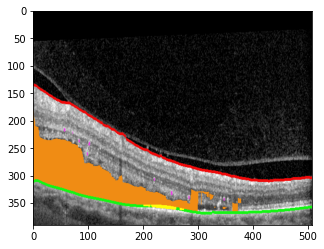

Retinal Fluid Detected Area (µm) : 87016.2
Foci Detected Area (µm) : 199.5
PED Detected Area (µm) : 1122.9
Lines distance is  43  Brights spots 7243  CAVE  3137


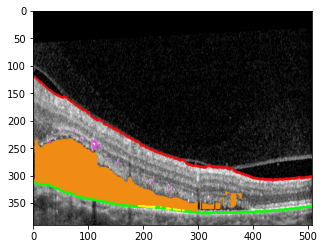

Retinal Fluid Detected Area (µm) : 94032.9
Foci Detected Area (µm) : 575.7
PED Detected Area (µm) : 592.8000000000001
Lines distance is  15  Brights spots 4587  CAVE  2672


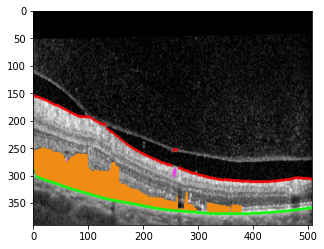

Retinal Fluid Detected Area (µm) : 67978.2
Foci Detected Area (µm) : 342.0
Lines distance is  34  Brights spots 3466  CAVE  2842


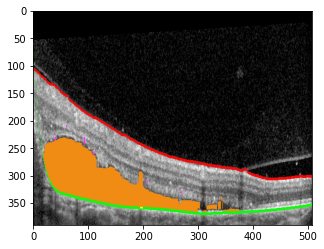

Retinal Fluid Detected Area (µm) : 89632.5
Foci Detected Area (µm) : 290.7
PED Detected Area (µm) : 28.5
Lines distance is  35  Brights spots 2868  CAVE  1360


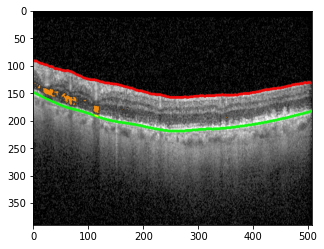

Retinal Fluid Detected Area (µm) : 3385.8
PED Detected Area (µm) : 39.9
Lines distance is  118  Brights spots 3916  CAVE  1328


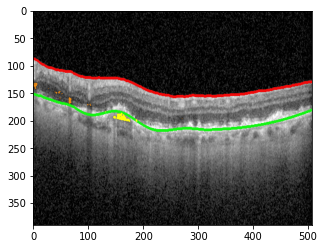

Retinal Fluid Detected Area (µm) : 832.2
PED Detected Area (µm) : 980.4
Lines distance is  485  Brights spots 3665  CAVE  1254


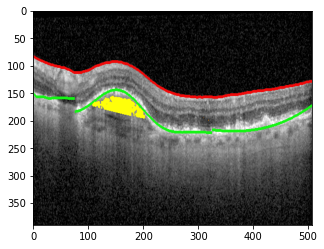

PED Detected Area (µm) : 9855.300000000001
Lines distance is  340  Brights spots 3707  CAVE  1223


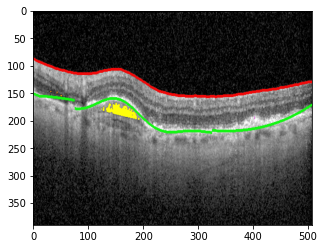

Retinal Fluid Detected Area (µm) : 96.9
Foci Detected Area (µm) : 5.7
PED Detected Area (µm) : 3876.0
Lines distance is  203  Brights spots 5214  CAVE  2439


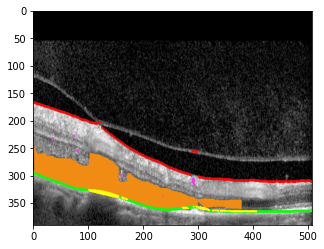

Retinal Fluid Detected Area (µm) : 76995.6
Foci Detected Area (µm) : 438.90000000000003
PED Detected Area (µm) : 3083.7000000000003
Lines distance is  581  Brights spots 3633  CAVE  1405


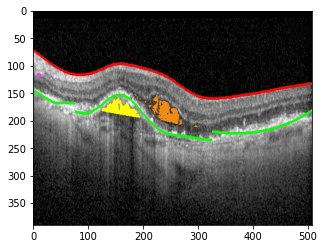

Retinal Fluid Detected Area (µm) : 7649.4
Foci Detected Area (µm) : 91.2
PED Detected Area (µm) : 5603.1
Lines distance is  722  Brights spots 4393  CAVE  1267


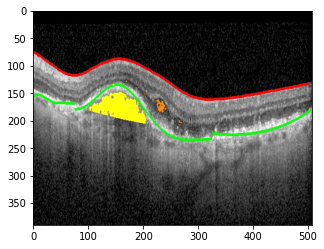

Retinal Fluid Detected Area (µm) : 1573.2
PED Detected Area (µm) : 17003.100000000002
Lines distance is  611  Brights spots 3722  CAVE  1228


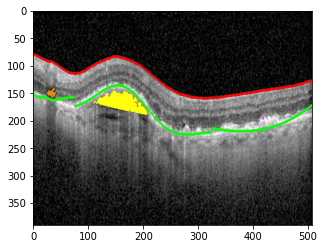

Retinal Fluid Detected Area (µm) : 860.7
Foci Detected Area (µm) : 22.8
PED Detected Area (µm) : 10784.4
Lines distance is  781  Brights spots 3396  CAVE  1140


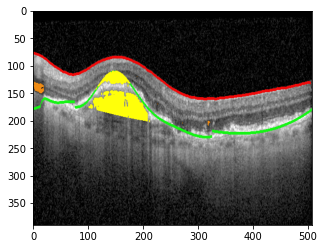

Retinal Fluid Detected Area (µm) : 1892.4
PED Detected Area (µm) : 22617.600000000002
Lines distance is  168  Brights spots 3499  CAVE  1710


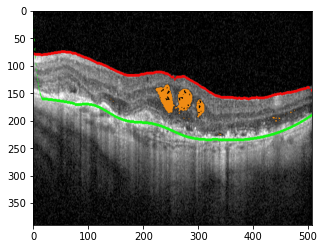

Retinal Fluid Detected Area (µm) : 11753.4
Lines distance is  310  Brights spots 3796  CAVE  1630


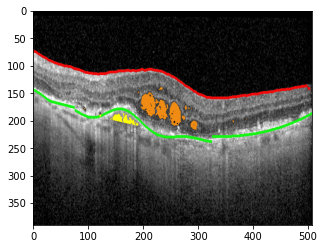

Retinal Fluid Detected Area (µm) : 12773.7
PED Detected Area (µm) : 1909.5
Lines distance is  156  Brights spots 3725  CAVE  1717


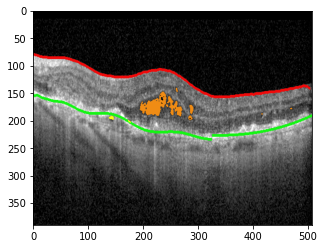

Retinal Fluid Detected Area (µm) : 9678.6
PED Detected Area (µm) : 188.1
Lines distance is  157  Brights spots 3508  CAVE  1852


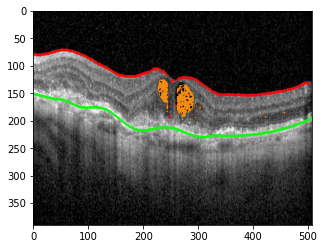

Retinal Fluid Detected Area (µm) : 10909.8
Lines distance is  103  Brights spots 3694  CAVE  1818


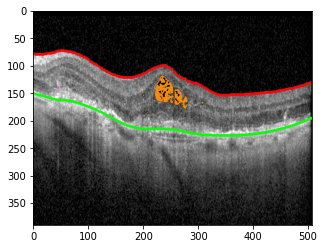

Retinal Fluid Detected Area (µm) : 8270.7
Foci Detected Area (µm) : 22.8
Lines distance is  365  Brights spots 2955  CAVE  1486


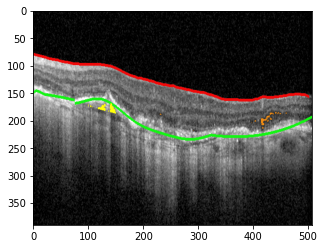

Retinal Fluid Detected Area (µm) : 1031.7
PED Detected Area (µm) : 929.1
Lines distance is  359  Brights spots 2602  CAVE  1575


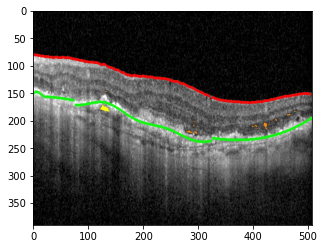

Retinal Fluid Detected Area (µm) : 917.7
PED Detected Area (µm) : 421.8
Lines distance is  518  Brights spots 4690  CAVE  1432


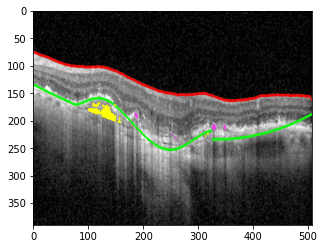

Foci Detected Area (µm) : 484.5
PED Detected Area (µm) : 3801.9
Lines distance is  100  Brights spots 5179  CAVE  1417


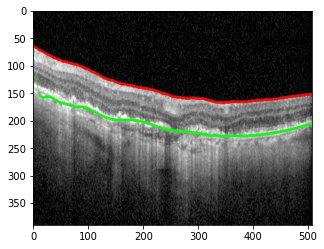

Lines distance is  136  Brights spots 5101  CAVE  1479


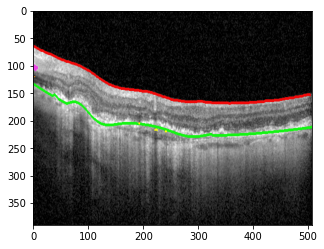

Foci Detected Area (µm) : 250.8
PED Detected Area (µm) : 114.0
Lines distance is  362  Brights spots 4449  CAVE  1443


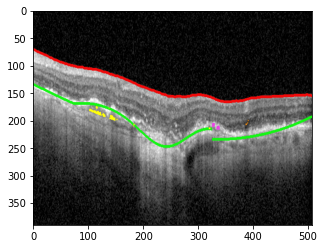

Retinal Fluid Detected Area (µm) : 96.9
Foci Detected Area (µm) : 165.3
PED Detected Area (µm) : 889.2
Lines distance is  85  Brights spots 5963  CAVE  1430


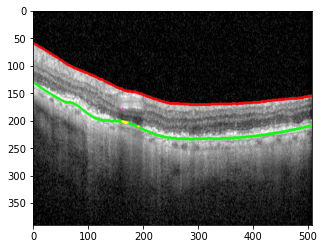

Foci Detected Area (µm) : 28.5
PED Detected Area (µm) : 228.0
Lines distance is  63  Brights spots 3705  CAVE  1469


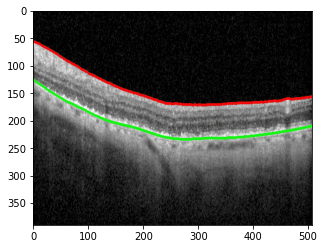

Lines distance is  64  Brights spots 5949  CAVE  1533


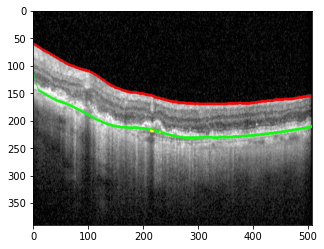

PED Detected Area (µm) : 102.60000000000001
Lines distance is  66  Brights spots 6093  CAVE  1277


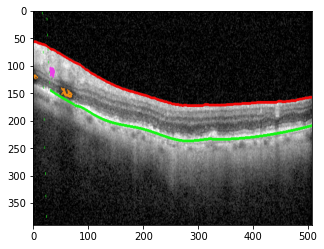

Retinal Fluid Detected Area (µm) : 1379.4
Foci Detected Area (µm) : 627.0
Lines distance is  17  Brights spots 6922  CAVE  1536


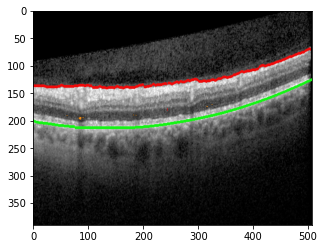

Retinal Fluid Detected Area (µm) : 193.8
Lines distance is  19  Brights spots 6598  CAVE  1537


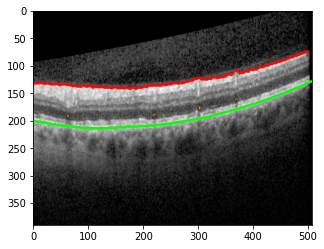

Retinal Fluid Detected Area (µm) : 267.9
Lines distance is  54  Brights spots 6217  CAVE  1507


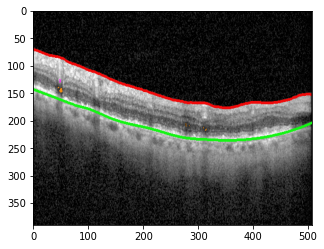

Retinal Fluid Detected Area (µm) : 353.4
Foci Detected Area (µm) : 39.9
Lines distance is  65  Brights spots 7124  CAVE  1299


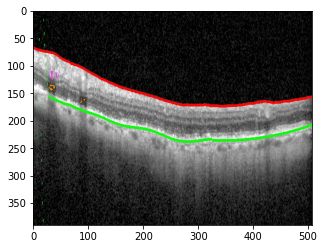

Retinal Fluid Detected Area (µm) : 450.3
Foci Detected Area (µm) : 193.8
Lines distance is  23  Brights spots 4992  CAVE  1654


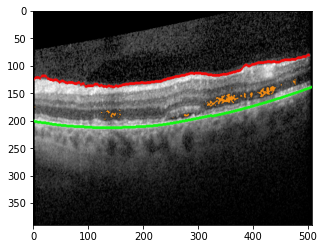

Retinal Fluid Detected Area (µm) : 5369.4
Lines distance is  12  Brights spots 7244  CAVE  1600


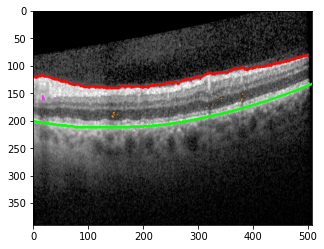

Retinal Fluid Detected Area (µm) : 393.3
Foci Detected Area (µm) : 165.3
Lines distance is  14  Brights spots 6007  CAVE  1545


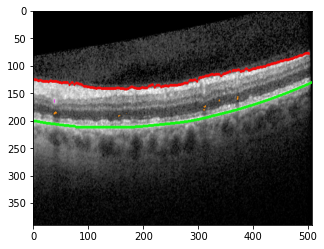

Retinal Fluid Detected Area (µm) : 450.3
Foci Detected Area (µm) : 22.8
Lines distance is  15  Brights spots 6352  CAVE  1621


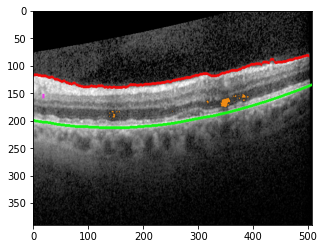

Retinal Fluid Detected Area (µm) : 1806.9
Foci Detected Area (µm) : 91.2
Lines distance is  92  Brights spots 4550  CAVE  1690


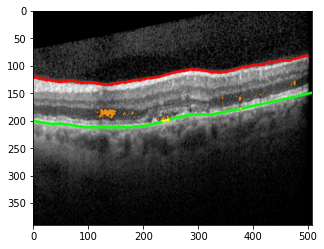

Retinal Fluid Detected Area (µm) : 3038.1
PED Detected Area (µm) : 193.8
Lines distance is  171  Brights spots 5119  CAVE  1770


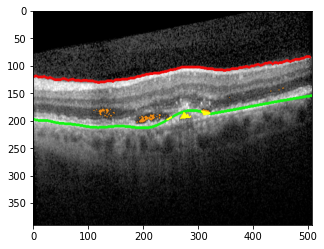

Retinal Fluid Detected Area (µm) : 2679.0
PED Detected Area (µm) : 1037.4


In [50]:

import os
import docx


#from scipy.interpolate import spline
from scipy.interpolate import interp1d
from sklearn.linear_model import LogisticRegression

MIN_ROW = 10
MAX_ROW = 400

mydoc = docx.Document()

os.chdir('/content/drive/My Drive/Colab Notebooks/AMD/Cropped/')
#os.chdir('/content/drive/My Drive/Colab Notebooks/AMD/Data')
image_files = os.listdir()
MICRO_PER_PIXEL = 5.7
#os.chdir('/content/drive/My Drive/Colab Notebooks/AMD/Cropped_Data/')
#for img_name in image_files:
#img_name = image_files[29]
#img = img[MIN_ROW:MAX_ROW,500:,:]
#new_name = 'cropped_'+img_name
#cv2.imwrite(new_name, img)

### THE PROBLEM IS WITH DETECTION OF ILM ---> FIX THAT --> OUTLIERS ARE BEING MARKED
for img_name in image_files:
  # img = cv2.imread(img_name)
  # img = img[MIN_ROW:MAX_ROW,500:,:]
  # new_name = 'cropped_'+img_name
  # new_path = '/content/drive/My Drive/Colab Notebooks/AMD/Cropped/'+new_name
  # cv2.imwrite(new_path, img)
  # continue
  
  ############ TASKS TO DO TUESDAY ############ 
  FLUID_THR = 75      ## TODO1: Make this adaptive with the intensity of scan higher value more FP
  ### TODO2: Separate out ROI (Region of Interest) + Add a Vertical line at left ==> Ignore open Contours
  ## Not having a line at the right would help us to avoid those crocodiles

  min_thrshld, max_thrshld = 0, 65 #65 ## TODO-1 MAKE THESE INTENSITIES DYNAMIC
  NUM_FLUID_PIXELS = NUM_FOCI_PIXELS = NUM_PED_PIXELS = 0
  RANGE_THRESHOLD = 145
  foci_mn_th, foci_mx_th = 210, 255
  RPE_THR = 200
  #img_name = image_files[29]
  #img_name = 'cropped_JB011.bmp'

  img = cv2.imread(img_name)
  #img = resize_img(img)
  md_img = apply_median_filter(img)
  
  clus_img = apply_k_mean_clustering(md_img)
  kernel = np.ones((5,5),np.uint8)
  erosion = cv2.erode(clus_img, kernel,iterations = 1)
  #erosion = cv.morphologyEx(clus_img, cv.MORPH_CLOSE, kernel)
  erosion = cv2.dilate(erosion, kernel,iterations = 1)

  ed_img = apply_canny_edge(erosion)
  ilm_pos, ilm_dict, min_ilm_row, seg_img = detect_ilm(ed_img)
  #dilated_fluid = cv2.dilate(erosion, kernel,iterations = 1)
  #dilated_fluid = apply_k_mean_clustering(dilated_fluid)
  ##fluid_fuzzy_clusters = fluid_clustering(md_img)
  ilm_rows, ilm_cols = [],[]
  for i in range(0, len(ilm_pos)):
    if i in ilm_dict:
      ilm_cols.append(i)
      ilm_rows.append(ilm_dict[i])

  #dbl_dil_edg = apply_canny_edge(dilated_fluid)
  #print("ILM Positions length is ", len(ilm_pos))
  #print("Length of ILM Dict", len(ilm_dict), ed_img.shape)
  #print("Length is ", len(ilm_dict), img_name)

  ########### DEBUGGING BLOCK ###########
  
  # fig = plt.figure(figsize=(15, 15))
  # ax = fig.add_subplot(1, 2, 1)
  # plt.imshow(img)
  # ax = fig.add_subplot(1, 2, 2)
  # plt.imshow(out_img)
  # plt.show()
  # #break
  # continue

  ########### DEBUGGING BLOCK ###########
  
  ## detecting RPE
  gray = cv2.cvtColor(md_img, cv2.COLOR_BGR2GRAY)
  vals = return_vals(ilm_dict)
  ilm_mode = stats.mode(vals)
  ilm_mode = ilm_mode[0][0]
  #print("ILM MODE VALS ",ilm_mode)
  #print(np.mean(gray))
  if np.mean(gray) < 51:
    RPE_THR -= 20
    max_thrshld -= 10
  if np.mean(gray) < 43:
    RPE_THR -= 20
    max_thrshld -= 10
  #print(np.mean(gray), RPE_THR, max_thrshld)
  (hi_rows, high_cols) = find_high_intensity_areas(gray, RPE_THR)
  #print("RPE VALS ",hi_rows)
  #print(ilm_mode)
  #print(ilm_dict)
  #print(len(ilm_dict))
  #print(len(hi_rows)) 
  #print(len(high_cols))
  #print(high_cols)

  total_bright_points = len(hi_rows)

  (hi_rows, high_cols) = remove_intensity_outliers(ilm_mode, ilm_dict, hi_rows, high_cols)
  '''
  rpe_func = interp1d(high_cols, hi_rows, fill_value='extrapolate', kind='cubic')
  new_hi_rows, new_hi_cols = [],[]
  print("Shape of gray ", gray.shape)
  for c in range(0, gray.shape[1]-1):
    print("X NEw is ", c)
    r = rpe_func(c)
    new_hi_rows.append(r)
    new_hi_cols.append(c)
  '''

  

  T_COLS = gray.shape[1]
  mode = stats.mode(hi_rows)
  rpe_row = mode[0][0]
  #print("RPE Rows and Cols are", len(hi_rows), len(high_cols))
  rpe_col = find_RPE_col(hi_rows, high_cols, rpe_row) 
  #f2 = interp1d(x, y, kind='cubic')
  #print("Size of image is ", gray.shape[1])
  rpe_pos, rpe_dict = segment_rpe(hi_rows, high_cols, gray.shape[1])

  new_hi_rows, new_hi_cols = [],[]
  
  for pos in rpe_pos:
    r,c = pos
    new_hi_rows.append(r)
    new_hi_cols.append(c)


  rpe_pos = []
  #rpe_dict = dict()
  for i in range(0, len(high_cols)):
    temp = hi_rows[i], high_cols[i]
    rpe_pos.append(temp)

  ################# Polynomial Fit for ILM ###################
  ilm_z = np.polyfit(ilm_cols, ilm_rows, 15)      ## need to use this for Foci segmentation
  ilm_equation = np.poly1d(ilm_z)

  ilm_curve = []
  ilm_curve_dict = dict()                 ## pass this dict to Foci segmentation
  #rpe_dict = dict()
  for i in range(0, T_COLS):
    curve_row = int(ilm_equation(i))
    temp = curve_row, i
    ilm_curve.append(temp)
    ilm_curve_dict[i] = curve_row

  ############ The idea of applying a ploynominal fit was taken from 
  ### Automated Segmentation of RPE Layer for the
  ### Detection of Age Macular Degeneration Using OCT
  ### Images

  z = np.polyfit(high_cols, hi_rows, 15)      ## need to use this for Foci segmentation
  bm = np.polyfit(high_cols, hi_rows, 3)      ## need to use this for fluid segmentation
  second = np.polyfit(high_cols, hi_rows, 2)      ## second order
  ft_or = np.polyfit(high_cols, hi_rows, 5)
  rpe_equation = np.poly1d(z)
  bm_equation = np.poly1d(bm)
  fo_equation = np.poly1d(ft_or)
  so_equation = np.poly1d(second)

  rpe_pos_curve = []
  rpe_pos_curve_dict = dict()                 ## pass this dict to Foci segmentation
  #rpe_dict = dict()
  for i in range(0, T_COLS):
    curve_row = int(rpe_equation(i))
    temp = curve_row, i
    rpe_pos_curve.append(temp)
    rpe_pos_curve_dict[i] = curve_row

  bm_pos_curve = []
  bm_pos_curve_dict = dict()                  ## pass this dict to Fluid segmentation
  #rpe_dict = dict()
  for i in range(0, T_COLS):
    bm_row = int(bm_equation(i))
    temp = bm_row, i
    bm_pos_curve.append(temp)
    bm_pos_curve_dict[i] = bm_row

  fo_pos_curve = []
  fo_pos_curve_dict = dict()
  #rpe_dict = dict()
  for i in range(0, T_COLS):
    fo_row = int(fo_equation(i))
    temp = fo_row, i
    fo_pos_curve.append(temp)
    fo_pos_curve_dict[i] = fo_row

  so_pos_curve = []
  so_pos_curve_dict = dict()
  #rpe_dict = dict()
  for i in range(0, T_COLS):
    so_row = int(so_equation(i))
    temp = so_row, i
    so_pos_curve.append(temp)
    so_pos_curve_dict[i] = so_row

  #print("Size of dictionaries ", len(fo_pos_curve_dict), len(bm_pos_curve_dict), len(rpe_pos_curve_dict))


  ## This estimate function is taking bright points and returning average of it ==> Line Curve
  #(new_hi_rows, new_hi_cols) = estimate_rpe(new_hi_rows, new_hi_cols, rpe_col)

  '''
  new_rpe_pos = []
  new_rpe_dict = dict()
  for i in range(T_COLS-1):
    #print("Col and Predicted Row", i, row_new)
    row_new = new_hi_rows[i]
    col_new = new_hi_cols[i]
    temp = (row_new, col_new)
    new_rpe_pos.append(temp)
    new_rpe_dict[col_new] = row_new
  '''
  #rpe_pos, rpe_dict = segment_rpe(gray, rpe_col, rpe_row, gray.shape[1])
  #print(rpe_dict)

  segmented_rpe_pos, segmented_rpe_dict, max_rpe_row = estimate_rpe(bm_pos_curve, rpe_pos_curve, T_COLS)

  ## detecting Fluid
  ############### Commented 03/09
  # roi = detect_roi(md_img, ilm_pos, rpe_pos, ilm_dict, segmented_rpe_dict)
  # ret, thresh1 = cv2.threshold(roi,FLUID_THR,255,cv2.THRESH_BINARY_INV)
  # temp_edges = anisodiff(md_img,100,80,0.075,(1,1),2.5,1)
  # gray_th = cv2.cvtColor(temp_edges, cv2.COLOR_BGR2GRAY)
  # out_img, areas = find_ret_contours(gray_th)
  # print(areas)
  ############### Commented 03/09
  detected_fluid_output = detect_fluid_contours(img, max_rpe_row, min_ilm_row)

  fluid_spots = detect_fluid_spots(detected_fluid_output, segmented_rpe_dict, ilm_dict, min_ilm_row, max_rpe_row)
  
  mid_dst = 89
  if 100 in ilm_dict:
    mid_dst = so_pos_curve_dict[100] - ilm_dict[100]


  new_dst = return_dist(ilm_dict, so_pos_curve_dict)

  if mid_dst < 100:
    max_thrshld -= 15

#  if 100 > mid_dst >= 90:
#    max_thrshld = 85

  fluid_pos, mx_row, mn_row = seg_fluid(gray, ilm_pos, rpe_pos, min_thrshld, max_thrshld, ilm_dict, bm_pos_curve_dict)

  foci_pos = seg_foci(gray, foci_mn_th, foci_mx_th, ilm_dict, segmented_rpe_dict, mx_row, mn_row, rpe_row)

  t_fluid = abrupt_change_fluid(gray, foci_mn_th, foci_mx_th, ilm_dict, segmented_rpe_dict, mx_row, mn_row, rpe_row)

  #count, th = 1, 10
  segmented_scan_ilm_rpe_final = img.copy()

  line_dst = return_dist(rpe_pos_curve_dict, so_pos_curve_dict)

  cave_dist = return_cave_dist(segmented_rpe_dict, ilm_curve_dict)

  if cave_dist < 2000:
    final_fluid = fluid_pos.copy()
  elif cave_dist < 5000:
    final_fluid =  fluid_spots.copy()
    #final_fluid.extend(fluid_spots)


  print("Lines distance is ", line_dst, " Brights spots", total_bright_points, " CAVE ", cave_dist)

  ########### DEBUGGING BLOCK ###########
  # fig = plt.figure(figsize=(15, 15))
  # ax = fig.add_subplot(1, 2, 1)
  # plt.imshow(img)
  # ax = fig.add_subplot(1, 2, 2)
  # plt.imshow(detected_fluid_output)
  # plt.show()
  # #break
  # continue

  ########### DEBUGGING BLOCK ###########

  so_pos_curve_dict, so_pos_curve = adjust_bm(line_dst, so_pos_curve_dict, so_pos_curve)

  ped_pos = seg_ped(gray, so_pos_curve_dict, segmented_rpe_dict)

  if 2100 > new_dst > 50:
    fluid_pos = []

  TWO = 2
  ZERO = 0

  for ilm_position in ilm_pos:
    (row, col) = ilm_position
    segmented_scan_ilm_rpe_final[row:row+5, col, ZERO] = 240
    segmented_scan_ilm_rpe_final[row:row+5, col, 1] = 10
    segmented_scan_ilm_rpe_final[row:row+5, col, TWO] = 10


  for f in final_fluid:
    NUM_FLUID_PIXELS += 1
    (row_f, col_f) = f
    segmented_scan_ilm_rpe_final[row_f:row_f+1, col_f, TWO] = 20
    segmented_scan_ilm_rpe_final[row_f:row_f+1, col_f, 1] = 140
    segmented_scan_ilm_rpe_final[row_f:row_f+1, col_f, ZERO] = 240

  for rpe_position in segmented_rpe_pos:
    (row_r, col_r) = rpe_position
    segmented_scan_ilm_rpe_final[row_r:row_r+5, col_r, 1] = 245
    segmented_scan_ilm_rpe_final[row_r:row_r+5, col_r, ZERO] = 20
    segmented_scan_ilm_rpe_final[row_r:row_r+5, col_r, TWO] = 20
    #segmented_scan_ilm_rpe_final[row_r+1, col_r, 1] = 255
    #segmented_scan_ilm_rpe_final[row_r+2, col_r, 1] = 255
    #segmented_scan_ilm_rpe_final[row_r+3, col_r, 1] = 255
    #segmented_scan_ilm_rpe_final[row_r+4, col_r, 1] = 255

  
  for bm_position in ped_pos:
    NUM_PED_PIXELS += 1
    (row_r, col_r) = bm_position
    segmented_scan_ilm_rpe_final[row_r:row_r+3, col_r, 1] = 255
    segmented_scan_ilm_rpe_final[row_r:row_r+3, col_r, ZERO] = 255
    segmented_scan_ilm_rpe_final[row_r:row_r+3, col_r, TWO] = 10
  

  for fc in foci_pos:
    NUM_FOCI_PIXELS += 1
    (row_r, col_r) = fc
    segmented_scan_ilm_rpe_final[row_r:row_r+5, col_r, 1] = 64
    segmented_scan_ilm_rpe_final[row_r:row_r+5, col_r, ZERO] = 235
    segmented_scan_ilm_rpe_final[row_r:row_r+5, col_r, TWO] = 230


  fig = plt.figure(figsize=(5, 5))
  ax = fig.add_subplot(1, 1, 1)
  plt.imshow(segmented_scan_ilm_rpe_final)
  
  #ax = fig.add_subplot(1, 2, 2)
  #plt.imshow(ed_img)
  # ax = fig.add_subplot(2, 2, 2)
  # plt.imshow(detected_fluid_output)
  # ax = fig.add_subplot(2, 2, 1)
  # plt.imshow(img)
  plt.show()

  #temp_edges = anisodiff(md_img,100,80,0.075,(1,1),2.5,1)
  #temp_edges = apply_canny_edge(apply_k_mean_clustering(apply_median_filter(img)))
  #n_edges = np.uint8(temp_edges)
  #n_edges = apply_canny_edge(n_edges)
  #plt.imshow(n_edges)
  #plt.show()

  quant_str = ""

  if NUM_FLUID_PIXELS > 10:
    quant_str += "Retinal Fluid Detected Area (µm) : "
    quant_str += str(round(NUM_FLUID_PIXELS * MICRO_PER_PIXEL, 3))
    quant_str += "\n\n"

    print("Retinal Fluid Detected Area (µm) :", round(NUM_FLUID_PIXELS * MICRO_PER_PIXEL, 3))

  else:
    quant_str += "No Retinal Fluid Detected in the Scan."
    quant_str += "\n\n"

  if NUM_FOCI_PIXELS > 0:
    quant_str += "Foci Detected Area (µm) : "
    quant_str += str(round(NUM_FOCI_PIXELS * MICRO_PER_PIXEL, 3))
    quant_str += "\n\n"

    print("Foci Detected Area (µm) :", NUM_FOCI_PIXELS * MICRO_PER_PIXEL)

  else:
    quant_str +=  "No Foci Detected in the Scan."
    quant_str += "\n\n"

  if NUM_PED_PIXELS > 0:
    quant_str += "PED Detected Area (µm) : "
    quant_str += str(round(NUM_PED_PIXELS * MICRO_PER_PIXEL, 3))
    quant_str += "\n\n"

    print("PED Detected Area (µm) :", NUM_PED_PIXELS * MICRO_PER_PIXEL)

  else:
    quant_str +=  "No Detachment in Pigment Epithelium."
    quant_str += "\n\n"

  # temp_img_path = "/content/"
  # temp_img_path += img_name
  # output_file_path = "/content/drive/My Drive/Colab Notebooks/AMD/Results"

  # cv2.imwrite(temp_img_path, segmented_scan_ilm_rpe_final)

  # mydoc.add_heading(img_name, 2)
  # input_img = '/content/drive/My Drive/Colab Notebooks/AMD/Cropped/'+img_name
  # mydoc.add_picture(input_img, width=docx.shared.Inches(4), height=docx.shared.Inches(3))
  # mydoc.add_picture(temp_img_path, width=docx.shared.Inches(4), height=docx.shared.Inches(3))
  # mydoc.save("/content/drive/My Drive/Colab Notebooks/AMD/Segmentation_Quant_Res.docx")

  # mydoc.add_paragraph(quant_str)
  # mydoc.save("/content/drive/My Drive/Colab Notebooks/AMD/Segmentation_Quant_Res.docx")

  #cv2.imread(img_name)
  #cv2.imwrite(output_file_path, segmented_scan_ilm_rpe_final)

  #break


In [ ]:
from skimage import data, img_as_float
from skimage.segmentation import chan_vese



In [ ]:
img = cv2.imread(img_name)
md_img = apply_median_filter(img)
gray = cv2.cvtColor(md_img, cv2.COLOR_BGR2GRAY)

chv = chan_vese(gray, mu=0.25, lambda1=1, lambda2=1, tol=1e-3, max_iter=200,
               dt=0.5, init_level_set="checkerboard", extended_output=True)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(gray, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Original Image", fontsize=12)

ax[1].imshow(chv[0], cmap="gray")
ax[1].set_axis_off()
title = "Chan-Vese segmentation - {} iterations".format(len(chv[2]))
ax[1].set_title(title, fontsize=12)

ax[2].imshow(chv[1], cmap="gray")
ax[2].set_axis_off()
ax[2].set_title("Final Level Set", fontsize=12)

ax[3].plot(chv[2])
ax[3].set_title("Evolution of energy over iterations", fontsize=12)

fig.tight_layout()
plt.show()

In [ ]:
from PIL import Image

data = chv[1].copy()

im_max = 255
data = abs(data.astype(np.float64) / data.max()) # normalize the data to 0 - 1
data = im_max * data # Now scale by 255
ls_img = data.astype(np.uint8)

temp = apply_k_mean_clustering(ls_img)
temp = apply_canny_edge(temp)
out_img2, areas = find_ret_contours(temp)
#plt.imshow(cv[1])
#ls_img.shape


In [ ]:
#temp = apply_k_mean_clustering(ls_img)
#temp = apply_canny_edge(temp)
plt.imshow(out_img2)
#data.shape
print(data.min())

Summary:
- Added a new method to segment fluid (Using Level Set)
- New method should NOT be called for All
- If Cave_dist > 2600 AND < 5000:
    - New method output is the output
- New method only detects until column 380
- Removed the noisy FP in fluid segmentation at the right end --- Stopping the loop a bit earlier

Task to do Saturday:
- Incorporate the context in append_fluid_spots() function
- Still start from a bit up (s_row - 10)
- Maintain a dictionary of starting values of fluid at col c
- whenever a new starting point is detected
- compare it with fluid_dict[col - 4] to get it smooth --> abs(this, -4) > 5 ==> Make it smooth SOMEHOW
